In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.models.segmentation import deeplabv3_resnet50

import albumentations as A
from albumentations.pytorch import ToTensorV2

from sklearn.model_selection import train_test_split


/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
class StrokeSegmentationDataset(Dataset):
    def __init__(self, image_paths, mask_paths, augmentations=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.augmentations = augmentations
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        # Load image and mask
        image = cv2.imread(self.image_paths[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_paths[idx], cv2.IMREAD_GRAYSCALE)
        
        # Normalize mask to 0/1
        mask = (mask > 127).astype(np.float32)
        
        if self.augmentations:
            augmented = self.augmentations(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']
        else:
            # If no augmentation, convert to tensor
            image = ToTensorV2()(image=image)['image']
            mask = torch.tensor(mask).unsqueeze(0)  # add channel dim
        
        return image, mask


In [3]:
train_transforms = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Normalize(mean=(0.485, 0.456, 0.406), 
                std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

val_transforms = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=(0.485, 0.456, 0.406), 
                std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])


In [4]:
base_path = "/kaggle/input/inme-veri-seti-stroke-dataset/İNME VERİ SETİ/YarısmaVeriSeti_1_Oturum"
png_path = os.path.join(base_path, "PNG")
masks_path = os.path.join(base_path, "MASKS")

image_paths = sorted([os.path.join(png_path, f) for f in os.listdir(png_path)])
mask_paths = sorted([os.path.join(masks_path, f) for f in os.listdir(masks_path)])

train_images, val_images, train_masks, val_masks = train_test_split(
    image_paths, mask_paths, test_size=0.2, random_state=42
)


In [5]:
train_dataset = StrokeSegmentationDataset(train_images, train_masks, augmentations=train_transforms)
val_dataset = StrokeSegmentationDataset(val_images, val_masks, augmentations=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=2)


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def get_deeplabv3():
    model = deeplabv3_resnet50(pretrained=True)
    model.classifier[4] = nn.Conv2d(256, 1, kernel_size=1)  # 1 class binary
    return model.to(device)

model = get_deeplabv3()


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth
100%|██████████| 161M/161M [00:11<00:00, 15.1MB/s] 


In [7]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor, threshold=0.5):
    outputs = (outputs > threshold).float()
    intersection = (outputs * labels).sum(dim=(1,2))
    union = outputs.sum(dim=(1,2)) + labels.sum(dim=(1,2)) - intersection
    iou = (intersection + 1e-6) / (union + 1e-6)
    return iou.mean().item()

def dice_pytorch(outputs: torch.Tensor, labels: torch.Tensor, threshold=0.5):
    outputs = (outputs > threshold).float()
    intersection = (outputs * labels).sum(dim=(1,2))
    dice = (2 * intersection + 1e-6) / (outputs.sum(dim=(1,2)) + labels.sum(dim=(1,2)) + 1e-6)
    return dice.mean().item()


In [8]:
import torch.optim as optim
from torchvision.utils import save_image

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 50
patience = 5
best_val_loss = np.inf
early_stop_counter = 0

os.makedirs("val_preds", exist_ok=True)

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    train_iou = 0
    train_dice = 0

    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device).squeeze(1)
        optimizer.zero_grad()
        outputs = model(images)['out'].squeeze(1)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        preds = torch.sigmoid(outputs)
        train_iou += iou_pytorch(preds, masks)
        train_dice += dice_pytorch(preds, masks)

    train_loss /= len(train_loader)
    train_iou /= len(train_loader)
    train_dice /= len(train_loader)

    model.eval()
    val_loss = 0
    val_iou = 0
    val_dice = 0

    with torch.no_grad():
        for i, (val_images, val_masks) in enumerate(val_loader):
            val_images, val_masks = val_images.to(device), val_masks.to(device).squeeze(1)
            val_outputs = model(val_images)['out'].squeeze(1)
            loss = criterion(val_outputs, val_masks)

            val_loss += loss.item()
            preds = torch.sigmoid(val_outputs)
            val_iou += iou_pytorch(preds, val_masks)
            val_dice += dice_pytorch(preds, val_masks)

            # Save images for first batch every 5 epochs
            if epoch % 5 == 0 and i == 0:
                for b in range(min(4, preds.shape[0])):
                    pred_mask = (preds[b] > 0.5).float()
                    save_image(pred_mask.unsqueeze(0), f"val_preds/epoch{epoch}_sample{b}_pred.png")

                    # Overlay original image + red mask
                    img = val_images[b].cpu()
                    img = img * torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
                    img = img + torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
                    img = torch.clamp(img, 0, 1)

                    overlay = img.clone()
                    overlay[0][pred_mask.bool()] = 1.0  # add red channel on mask pixels
                    save_image(overlay, f"val_preds/epoch{epoch}_sample{b}_overlay.png")

    val_loss /= len(val_loader)
    val_iou /= len(val_loader)
    val_dice /= len(val_loader)

    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {train_loss:.4f}, IoU: {train_iou:.4f}, Dice: {train_dice:.4f} | "
          f"Val Loss: {val_loss:.4f}, IoU: {val_iou:.4f}, Dice: {val_dice:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
        torch.save(model.state_dict(), "best_deeplabv3.pth")
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print("Early stopping triggered.")
            break

print("Training complete!")


Epoch 1/50 | Train Loss: 0.7398, IoU: 0.0024, Dice: 0.0047 | Val Loss: 1.0529, IoU: 0.0025, Dice: 0.0049
Epoch 2/50 | Train Loss: 0.5527, IoU: 0.3851, Dice: 0.3876 | Val Loss: 0.5027, IoU: 0.6041, Dice: 0.6073
Epoch 3/50 | Train Loss: 0.4108, IoU: 0.6774, Dice: 0.6790 | Val Loss: 0.4226, IoU: 0.6104, Dice: 0.6172
Epoch 4/50 | Train Loss: 0.3501, IoU: 0.6860, Dice: 0.6895 | Val Loss: 0.3204, IoU: 0.7750, Dice: 0.7750
Epoch 5/50 | Train Loss: 0.3093, IoU: 0.7367, Dice: 0.7403 | Val Loss: 0.3048, IoU: 0.7500, Dice: 0.7500
Epoch 6/50 | Train Loss: 0.2783, IoU: 0.7126, Dice: 0.7128 | Val Loss: 0.2689, IoU: 0.7250, Dice: 0.7250
Epoch 7/50 | Train Loss: 0.2563, IoU: 0.7250, Dice: 0.7250 | Val Loss: 0.2502, IoU: 0.7500, Dice: 0.7500
Epoch 8/50 | Train Loss: 0.2339, IoU: 0.7438, Dice: 0.7439 | Val Loss: 0.2248, IoU: 0.7500, Dice: 0.7500
Epoch 9/50 | Train Loss: 0.2142, IoU: 0.7506, Dice: 0.7511 | Val Loss: 0.2076, IoU: 0.7500, Dice: 0.7500
Epoch 10/50 | Train Loss: 0.1986, IoU: 0.7063, Dice: 0.

In [11]:
import torch.nn.functional as F
from tqdm import tqdm
class SegNet(nn.Module):
    def __init__(self, n_channels=3, n_classes=1):
        super(SegNet, self).__init__()

        def conv_block(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
            )

        self.encoder1 = conv_block(n_channels, 64)
        self.pool1 = nn.MaxPool2d(2, 2, return_indices=True)

        self.encoder2 = conv_block(64, 128)
        self.pool2 = nn.MaxPool2d(2, 2, return_indices=True)

        self.encoder3 = conv_block(128, 256)
        self.pool3 = nn.MaxPool2d(2, 2, return_indices=True)

        self.encoder4 = conv_block(256, 512)
        self.pool4 = nn.MaxPool2d(2, 2, return_indices=True)

        self.encoder5 = conv_block(512, 512)
        self.pool5 = nn.MaxPool2d(2, 2, return_indices=True)

        self.decoder5 = conv_block(512, 512)
        self.unpool5 = nn.MaxUnpool2d(2, 2)

        self.decoder4 = conv_block(512, 256)
        self.unpool4 = nn.MaxUnpool2d(2, 2)

        self.decoder3 = conv_block(256, 128)
        self.unpool3 = nn.MaxUnpool2d(2, 2)

        self.decoder2 = conv_block(128, 64)
        self.unpool2 = nn.MaxUnpool2d(2, 2)

        self.decoder1 = conv_block(64, 64)
        self.unpool1 = nn.MaxUnpool2d(2, 2)

        self.final_conv = nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):
        # Encoder
        x1 = self.encoder1(x)
        size1 = x1.size()
        x1p, idx1 = self.pool1(x1)

        x2 = self.encoder2(x1p)
        size2 = x2.size()
        x2p, idx2 = self.pool2(x2)

        x3 = self.encoder3(x2p)
        size3 = x3.size()
        x3p, idx3 = self.pool3(x3)

        x4 = self.encoder4(x3p)
        size4 = x4.size()
        x4p, idx4 = self.pool4(x4)

        x5 = self.encoder5(x4p)
        size5 = x5.size()
        x5p, idx5 = self.pool5(x5)

        # Decoder
        d5 = self.unpool5(x5p, idx5, output_size=size5)
        d5 = self.decoder5(d5)

        d4 = self.unpool4(d5, idx4, output_size=size4)
        d4 = self.decoder4(d4)

        d3 = self.unpool3(d4, idx3, output_size=size3)
        d3 = self.decoder3(d3)

        d2 = self.unpool2(d3, idx2, output_size=size2)
        d2 = self.decoder2(d2)

        d1 = self.unpool1(d2, idx1, output_size=size1)
        d1 = self.decoder1(d1)

        out = self.final_conv(d1)
        return out


In [14]:
class StrokeDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = cv2.imread(self.image_paths[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_paths[idx], cv2.IMREAD_GRAYSCALE)
        mask = (mask > 0).astype(np.float32)  # binary mask

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        return image, mask.unsqueeze(0)  # Add channel dimension for mask


In [15]:
train_transform = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])


In [16]:
# Paths (replace with your paths)
image_paths = sorted([os.path.join(png_path, f) for f in os.listdir(png_path)])
mask_paths = sorted([os.path.join(masks_path, f) for f in os.listdir(masks_path)])

train_images, val_images, train_masks, val_masks = train_test_split(
    image_paths, mask_paths, test_size=0.2, random_state=42)

train_dataset = StrokeDataset(train_images, train_masks, transform=train_transform)
val_dataset = StrokeDataset(val_images, val_masks, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=2)


In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SegNet(n_channels=3, n_classes=1).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor, threshold=0.5):
    # Apply sigmoid and threshold
    outputs = torch.sigmoid(outputs)
    outputs = (outputs > threshold).float()

    intersection = (outputs * labels).sum((1, 2, 3))
    union = ((outputs + labels) - (outputs * labels)).sum((1, 2, 3))

    iou = (intersection + 1e-6) / (union + 1e-6)
    return iou.mean()

num_epochs = 50
best_iou = 0

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    train_iou = 0

    for images, masks in tqdm(train_loader):
        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_iou += iou_pytorch(outputs, masks).item()

    train_loss /= len(train_loader)
    train_iou /= len(train_loader)

    # Validation
    model.eval()
    val_loss = 0
    val_iou = 0

    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device)
            masks = masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)

            val_loss += loss.item()
            val_iou += iou_pytorch(outputs, masks).item()

    val_loss /= len(val_loader)
    val_iou /= len(val_loader)

    print(f"Epoch [{epoch+1}/{num_epochs}]"
          f" Train Loss: {train_loss:.4f} | Train IoU: {train_iou:.4f} "
          f"Val Loss: {val_loss:.4f} | Val IoU: {val_iou:.4f}")

    # Save best model
    if val_iou > best_iou:
        best_iou = val_iou
        torch.save(model.state_dict(), "best_segnet_model.pth")
        print("Best model saved!")


100%|██████████| 20/20 [00:03<00:00,  6.31it/s]


Epoch [1/50] Train Loss: 0.6445 | Train IoU: 0.0076 Val Loss: 0.6820 | Val IoU: 0.0052
Best model saved!


100%|██████████| 20/20 [00:03<00:00,  6.36it/s]


Epoch [2/50] Train Loss: 0.5050 | Train IoU: 0.0036 Val Loss: 0.5110 | Val IoU: 0.0002


100%|██████████| 20/20 [00:03<00:00,  6.38it/s]


Epoch [3/50] Train Loss: 0.4047 | Train IoU: 0.2375 Val Loss: 0.4814 | Val IoU: 0.0000


100%|██████████| 20/20 [00:03<00:00,  6.33it/s]


Epoch [4/50] Train Loss: 0.3683 | Train IoU: 0.4438 Val Loss: 0.3605 | Val IoU: 0.4250
Best model saved!


100%|██████████| 20/20 [00:03<00:00,  6.28it/s]


Epoch [5/50] Train Loss: 0.3470 | Train IoU: 0.4875 Val Loss: 0.3411 | Val IoU: 0.2750


100%|██████████| 20/20 [00:03<00:00,  6.34it/s]


Epoch [6/50] Train Loss: 0.3290 | Train IoU: 0.4813 Val Loss: 0.3242 | Val IoU: 0.4500
Best model saved!


100%|██████████| 20/20 [00:03<00:00,  6.33it/s]


Epoch [7/50] Train Loss: 0.3182 | Train IoU: 0.5125 Val Loss: 0.3242 | Val IoU: 0.3750


100%|██████████| 20/20 [00:03<00:00,  6.33it/s]


Epoch [8/50] Train Loss: 0.3042 | Train IoU: 0.4688 Val Loss: 0.3239 | Val IoU: 0.0000


100%|██████████| 20/20 [00:03<00:00,  6.34it/s]


Epoch [9/50] Train Loss: 0.2941 | Train IoU: 0.4000 Val Loss: 0.2949 | Val IoU: 0.4500


100%|██████████| 20/20 [00:03<00:00,  6.38it/s]


Epoch [10/50] Train Loss: 0.2802 | Train IoU: 0.5188 Val Loss: 0.2789 | Val IoU: 0.5500
Best model saved!


100%|██████████| 20/20 [00:03<00:00,  6.36it/s]


Epoch [11/50] Train Loss: 0.2695 | Train IoU: 0.5250 Val Loss: 0.2704 | Val IoU: 0.5000


100%|██████████| 20/20 [00:03<00:00,  6.38it/s]


Epoch [12/50] Train Loss: 0.2596 | Train IoU: 0.5625 Val Loss: 0.2633 | Val IoU: 0.5250


100%|██████████| 20/20 [00:03<00:00,  6.40it/s]


Epoch [13/50] Train Loss: 0.2503 | Train IoU: 0.5688 Val Loss: 0.2518 | Val IoU: 0.5250


100%|██████████| 20/20 [00:03<00:00,  6.34it/s]


Epoch [14/50] Train Loss: 0.2420 | Train IoU: 0.5875 Val Loss: 0.2417 | Val IoU: 0.5500


100%|██████████| 20/20 [00:03<00:00,  6.36it/s]


Epoch [15/50] Train Loss: 0.2345 | Train IoU: 0.5875 Val Loss: 0.2330 | Val IoU: 0.6000
Best model saved!


100%|██████████| 20/20 [00:03<00:00,  6.34it/s]


Epoch [16/50] Train Loss: 0.2292 | Train IoU: 0.5563 Val Loss: 0.2288 | Val IoU: 0.7000
Best model saved!


100%|██████████| 20/20 [00:03<00:00,  6.37it/s]


Epoch [17/50] Train Loss: 0.2210 | Train IoU: 0.5188 Val Loss: 0.2230 | Val IoU: 0.4250


100%|██████████| 20/20 [00:03<00:00,  6.38it/s]


Epoch [18/50] Train Loss: 0.2146 | Train IoU: 0.5813 Val Loss: 0.2172 | Val IoU: 0.4750


100%|██████████| 20/20 [00:03<00:00,  6.36it/s]


Epoch [19/50] Train Loss: 0.2073 | Train IoU: 0.5563 Val Loss: 0.2071 | Val IoU: 0.3750


100%|██████████| 20/20 [00:03<00:00,  6.37it/s]


Epoch [20/50] Train Loss: 0.2005 | Train IoU: 0.5688 Val Loss: 0.1990 | Val IoU: 0.4000


100%|██████████| 20/20 [00:03<00:00,  6.39it/s]


Epoch [21/50] Train Loss: 0.1944 | Train IoU: 0.5625 Val Loss: 0.1921 | Val IoU: 0.5250


100%|██████████| 20/20 [00:03<00:00,  6.37it/s]


Epoch [22/50] Train Loss: 0.1885 | Train IoU: 0.6063 Val Loss: 0.1844 | Val IoU: 0.5250


100%|██████████| 20/20 [00:03<00:00,  6.37it/s]


Epoch [23/50] Train Loss: 0.1872 | Train IoU: 0.6000 Val Loss: 0.1823 | Val IoU: 0.3250


100%|██████████| 20/20 [00:03<00:00,  6.39it/s]


Epoch [24/50] Train Loss: 0.1792 | Train IoU: 0.6250 Val Loss: 0.1783 | Val IoU: 0.5000


100%|██████████| 20/20 [00:03<00:00,  6.40it/s]


Epoch [25/50] Train Loss: 0.1731 | Train IoU: 0.6125 Val Loss: 0.1702 | Val IoU: 0.5000


100%|██████████| 20/20 [00:03<00:00,  6.38it/s]


Epoch [26/50] Train Loss: 0.1676 | Train IoU: 0.6250 Val Loss: 0.1643 | Val IoU: 0.5500


100%|██████████| 20/20 [00:03<00:00,  6.38it/s]


Epoch [27/50] Train Loss: 0.1627 | Train IoU: 0.6500 Val Loss: 0.1590 | Val IoU: 0.6250


100%|██████████| 20/20 [00:03<00:00,  6.40it/s]


Epoch [28/50] Train Loss: 0.1581 | Train IoU: 0.6750 Val Loss: 0.1528 | Val IoU: 0.5250


100%|██████████| 20/20 [00:03<00:00,  6.41it/s]


Epoch [29/50] Train Loss: 0.1534 | Train IoU: 0.6500 Val Loss: 0.1484 | Val IoU: 0.6500


100%|██████████| 20/20 [00:03<00:00,  6.38it/s]


Epoch [30/50] Train Loss: 0.1492 | Train IoU: 0.6500 Val Loss: 0.1443 | Val IoU: 0.6500


100%|██████████| 20/20 [00:03<00:00,  6.39it/s]


Epoch [31/50] Train Loss: 0.1449 | Train IoU: 0.6625 Val Loss: 0.1398 | Val IoU: 0.5250


100%|██████████| 20/20 [00:03<00:00,  6.38it/s]


Epoch [32/50] Train Loss: 0.1407 | Train IoU: 0.6563 Val Loss: 0.1368 | Val IoU: 0.5000


100%|██████████| 20/20 [00:03<00:00,  6.40it/s]


Epoch [33/50] Train Loss: 0.1364 | Train IoU: 0.6688 Val Loss: 0.1328 | Val IoU: 0.6750


100%|██████████| 20/20 [00:03<00:00,  6.38it/s]


Epoch [34/50] Train Loss: 0.1327 | Train IoU: 0.6563 Val Loss: 0.1291 | Val IoU: 0.5750


100%|██████████| 20/20 [00:03<00:00,  6.39it/s]


Epoch [35/50] Train Loss: 0.1288 | Train IoU: 0.6688 Val Loss: 0.1236 | Val IoU: 0.5500


100%|██████████| 20/20 [00:03<00:00,  6.38it/s]


Epoch [36/50] Train Loss: 0.1250 | Train IoU: 0.6813 Val Loss: 0.1182 | Val IoU: 0.7000


100%|██████████| 20/20 [00:03<00:00,  6.40it/s]


Epoch [37/50] Train Loss: 0.1214 | Train IoU: 0.6750 Val Loss: 0.1175 | Val IoU: 0.6750


100%|██████████| 20/20 [00:03<00:00,  6.41it/s]


Epoch [38/50] Train Loss: 0.1178 | Train IoU: 0.6688 Val Loss: 0.1138 | Val IoU: 0.5750


100%|██████████| 20/20 [00:03<00:00,  6.39it/s]


Epoch [39/50] Train Loss: 0.1144 | Train IoU: 0.6813 Val Loss: 0.1100 | Val IoU: 0.6750


100%|██████████| 20/20 [00:03<00:00,  6.40it/s]


Epoch [40/50] Train Loss: 0.1110 | Train IoU: 0.6750 Val Loss: 0.1054 | Val IoU: 0.6500


100%|██████████| 20/20 [00:03<00:00,  6.36it/s]


Epoch [41/50] Train Loss: 0.1078 | Train IoU: 0.6750 Val Loss: 0.1049 | Val IoU: 0.7000


100%|██████████| 20/20 [00:03<00:00,  6.35it/s]


Epoch [42/50] Train Loss: 0.1044 | Train IoU: 0.6813 Val Loss: 0.1025 | Val IoU: 0.7000


100%|██████████| 20/20 [00:03<00:00,  6.38it/s]


Epoch [43/50] Train Loss: 0.1022 | Train IoU: 0.6750 Val Loss: 0.0987 | Val IoU: 0.7000


100%|██████████| 20/20 [00:03<00:00,  6.37it/s]


Epoch [44/50] Train Loss: 0.0994 | Train IoU: 0.6813 Val Loss: 0.0948 | Val IoU: 0.7000


100%|██████████| 20/20 [00:03<00:00,  6.38it/s]


Epoch [45/50] Train Loss: 0.0963 | Train IoU: 0.6813 Val Loss: 0.0933 | Val IoU: 0.7000


100%|██████████| 20/20 [00:03<00:00,  6.38it/s]


Epoch [46/50] Train Loss: 0.0939 | Train IoU: 0.6813 Val Loss: 0.0909 | Val IoU: 0.7000


100%|██████████| 20/20 [00:03<00:00,  6.36it/s]


Epoch [47/50] Train Loss: 0.0912 | Train IoU: 0.6813 Val Loss: 0.0925 | Val IoU: 0.7000


100%|██████████| 20/20 [00:03<00:00,  6.38it/s]


Epoch [48/50] Train Loss: 0.0901 | Train IoU: 0.6813 Val Loss: 0.0858 | Val IoU: 0.7000


100%|██████████| 20/20 [00:03<00:00,  6.39it/s]


Epoch [49/50] Train Loss: 0.0877 | Train IoU: 0.6813 Val Loss: 0.0817 | Val IoU: 0.7000


100%|██████████| 20/20 [00:03<00:00,  6.34it/s]


Epoch [50/50] Train Loss: 0.0840 | Train IoU: 0.6813 Val Loss: 0.0855 | Val IoU: 0.6250


RESUNET

In [18]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),

            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class ResBlock(nn.Module):
    def __init__(self, channels):
        super(ResBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(channels, channels, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(channels)

    def forward(self, x):
        residual = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += residual
        out = self.relu(out)
        return out

class ResUNet(nn.Module):
    def __init__(self, n_channels=3, n_classes=1):
        super(ResUNet, self).__init__()

        self.dconv_down1 = DoubleConv(n_channels, 64)
        self.resblock1 = ResBlock(64)
        self.pool1 = nn.MaxPool2d(2)

        self.dconv_down2 = DoubleConv(64, 128)
        self.resblock2 = ResBlock(128)
        self.pool2 = nn.MaxPool2d(2)

        self.dconv_down3 = DoubleConv(128, 256)
        self.resblock3 = ResBlock(256)
        self.pool3 = nn.MaxPool2d(2)

        self.dconv_down4 = DoubleConv(256, 512)
        self.resblock4 = ResBlock(512)
        self.pool4 = nn.MaxPool2d(2)

        self.bottleneck = DoubleConv(512, 1024)
        self.resblock_bottleneck = ResBlock(1024)

        self.up4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dconv_up4 = DoubleConv(1024, 512)
        self.resblock_up4 = ResBlock(512)

        self.up3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dconv_up3 = DoubleConv(512, 256)
        self.resblock_up3 = ResBlock(256)

        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dconv_up2 = DoubleConv(256, 128)
        self.resblock_up2 = ResBlock(128)

        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dconv_up1 = DoubleConv(128, 64)
        self.resblock_up1 = ResBlock(64)

        self.out_conv = nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):
        # Encoder
        conv1 = self.dconv_down1(x)
        conv1 = self.resblock1(conv1)
        x1 = self.pool1(conv1)

        conv2 = self.dconv_down2(x1)
        conv2 = self.resblock2(conv2)
        x2 = self.pool2(conv2)

        conv3 = self.dconv_down3(x2)
        conv3 = self.resblock3(conv3)
        x3 = self.pool3(conv3)

        conv4 = self.dconv_down4(x3)
        conv4 = self.resblock4(conv4)
        x4 = self.pool4(conv4)

        bottleneck = self.bottleneck(x4)
        bottleneck = self.resblock_bottleneck(bottleneck)

        # Decoder
        up4 = self.up4(bottleneck)
        up4 = torch.cat([up4, conv4], dim=1)
        up4 = self.dconv_up4(up4)
        up4 = self.resblock_up4(up4)

        up3 = self.up3(up4)
        up3 = torch.cat([up3, conv3], dim=1)
        up3 = self.dconv_up3(up3)
        up3 = self.resblock_up3(up3)

        up2 = self.up2(up3)
        up2 = torch.cat([up2, conv2], dim=1)
        up2 = self.dconv_up2(up2)
        up2 = self.resblock_up2(up2)

        up1 = self.up1(up2)
        up1 = torch.cat([up1, conv1], dim=1)
        up1 = self.dconv_up1(up1)
        up1 = self.resblock_up1(up1)

        out = self.out_conv(up1)
        return out


In [19]:
class StrokeDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = cv2.imread(self.image_paths[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_paths[idx], cv2.IMREAD_GRAYSCALE)
        mask = (mask > 0).astype(np.float32)  # binary mask

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        return image, mask.unsqueeze(0)


In [20]:
train_transform = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])


In [21]:
image_paths = sorted([os.path.join(png_path, f) for f in os.listdir(png_path)])
mask_paths = sorted([os.path.join(masks_path, f) for f in os.listdir(masks_path)])

train_images, val_images, train_masks, val_masks = train_test_split(
    image_paths, mask_paths, test_size=0.2, random_state=42)

train_dataset = StrokeDataset(train_images, train_masks, transform=train_transform)
val_dataset = StrokeDataset(val_images, val_masks, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=2)


In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ResUNet(n_channels=3, n_classes=1).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor, threshold=0.5):
    outputs = torch.sigmoid(outputs)
    outputs = (outputs > threshold).float()
    intersection = (outputs * labels).sum((1, 2, 3))
    union = ((outputs + labels) - (outputs * labels)).sum((1, 2, 3))
    iou = (intersection + 1e-6) / (union + 1e-6)
    return iou.mean()

num_epochs = 50
best_iou = 0

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    train_iou = 0

    for images, masks in tqdm(train_loader):
        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_iou += iou_pytorch(outputs, masks).item()

    train_loss /= len(train_loader)
    train_iou /= len(train_loader)

    model.eval()
    val_loss = 0
    val_iou = 0

    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            loss = criterion(outputs, masks)

            val_loss += loss.item()
            val_iou += iou_pytorch(outputs, masks).item()

    val_loss /= len(val_loader)
    val_iou /= len(val_loader)

    print(f"Epoch [{epoch+1}/{num_epochs}]"
          f" Train Loss: {train_loss:.4f} | Train IoU: {train_iou:.4f} "
          f"Val Loss: {val_loss:.4f} | Val IoU: {val_iou:.4f}")

    if val_iou > best_iou:
        best_iou = val_iou
        torch.save(model.state_dict(), "best_resunet_model.pth")
        print("Best model saved!")


100%|██████████| 20/20 [00:08<00:00,  2.35it/s]


Epoch [1/50] Train Loss: 0.5169 | Train IoU: 0.0036 Val Loss: 0.5212 | Val IoU: 0.0084
Best model saved!


100%|██████████| 20/20 [00:08<00:00,  2.35it/s]


Epoch [2/50] Train Loss: 0.2910 | Train IoU: 0.0815 Val Loss: 0.3882 | Val IoU: 0.0000


100%|██████████| 20/20 [00:08<00:00,  2.35it/s]


Epoch [3/50] Train Loss: 0.2063 | Train IoU: 0.5188 Val Loss: 0.2160 | Val IoU: 0.5251
Best model saved!


100%|██████████| 20/20 [00:08<00:00,  2.36it/s]


Epoch [4/50] Train Loss: 0.1813 | Train IoU: 0.5500 Val Loss: 0.1925 | Val IoU: 0.6000
Best model saved!


100%|██████████| 20/20 [00:08<00:00,  2.36it/s]


Epoch [5/50] Train Loss: 0.1676 | Train IoU: 0.5750 Val Loss: 0.1693 | Val IoU: 0.7000
Best model saved!


100%|██████████| 20/20 [00:08<00:00,  2.35it/s]


Epoch [6/50] Train Loss: 0.1553 | Train IoU: 0.5688 Val Loss: 0.2139 | Val IoU: 0.0758


100%|██████████| 20/20 [00:08<00:00,  2.35it/s]


Epoch [7/50] Train Loss: 0.1488 | Train IoU: 0.5687 Val Loss: 0.1404 | Val IoU: 0.7000


100%|██████████| 20/20 [00:08<00:00,  2.35it/s]


Epoch [8/50] Train Loss: 0.1366 | Train IoU: 0.6062 Val Loss: 0.1325 | Val IoU: 0.6000


100%|██████████| 20/20 [00:08<00:00,  2.35it/s]


Epoch [9/50] Train Loss: 0.1292 | Train IoU: 0.6188 Val Loss: 0.1353 | Val IoU: 0.6000


100%|██████████| 20/20 [00:08<00:00,  2.35it/s]


Epoch [10/50] Train Loss: 0.1229 | Train IoU: 0.6125 Val Loss: 0.1150 | Val IoU: 0.6750


100%|██████████| 20/20 [00:08<00:00,  2.36it/s]


Epoch [11/50] Train Loss: 0.1157 | Train IoU: 0.6000 Val Loss: 0.1123 | Val IoU: 0.6000


100%|██████████| 20/20 [00:08<00:00,  2.35it/s]


Epoch [12/50] Train Loss: 0.1111 | Train IoU: 0.6250 Val Loss: 0.1130 | Val IoU: 0.6000


100%|██████████| 20/20 [00:08<00:00,  2.35it/s]


Epoch [13/50] Train Loss: 0.1064 | Train IoU: 0.6250 Val Loss: 0.1003 | Val IoU: 0.6000


100%|██████████| 20/20 [00:08<00:00,  2.35it/s]


Epoch [14/50] Train Loss: 0.1018 | Train IoU: 0.6250 Val Loss: 0.0970 | Val IoU: 0.6750


100%|██████████| 20/20 [00:08<00:00,  2.35it/s]


Epoch [15/50] Train Loss: 0.0991 | Train IoU: 0.6313 Val Loss: 0.0946 | Val IoU: 0.6750


100%|██████████| 20/20 [00:08<00:00,  2.35it/s]


Epoch [16/50] Train Loss: 0.0940 | Train IoU: 0.6250 Val Loss: 0.0890 | Val IoU: 0.7000


100%|██████████| 20/20 [00:08<00:00,  2.35it/s]


Epoch [17/50] Train Loss: 0.0899 | Train IoU: 0.6125 Val Loss: 0.0839 | Val IoU: 0.7000


100%|██████████| 20/20 [00:08<00:00,  2.36it/s]


Epoch [18/50] Train Loss: 0.0863 | Train IoU: 0.6375 Val Loss: 0.0813 | Val IoU: 0.7000


100%|██████████| 20/20 [00:08<00:00,  2.35it/s]


Epoch [19/50] Train Loss: 0.0835 | Train IoU: 0.6125 Val Loss: 0.1079 | Val IoU: 0.1500


100%|██████████| 20/20 [00:08<00:00,  2.35it/s]


Epoch [20/50] Train Loss: 0.0815 | Train IoU: 0.6750 Val Loss: 0.1181 | Val IoU: 0.0001


100%|██████████| 20/20 [00:08<00:00,  2.36it/s]


Epoch [21/50] Train Loss: 0.0779 | Train IoU: 0.6688 Val Loss: 0.0726 | Val IoU: 0.7000


100%|██████████| 20/20 [00:08<00:00,  2.35it/s]


Epoch [22/50] Train Loss: 0.0743 | Train IoU: 0.6500 Val Loss: 0.0690 | Val IoU: 0.7000


100%|██████████| 20/20 [00:08<00:00,  2.35it/s]


Epoch [23/50] Train Loss: 0.0714 | Train IoU: 0.6438 Val Loss: 0.0667 | Val IoU: 0.6000


100%|██████████| 20/20 [00:08<00:00,  2.35it/s]


Epoch [24/50] Train Loss: 0.0689 | Train IoU: 0.6375 Val Loss: 0.0646 | Val IoU: 0.6000


100%|██████████| 20/20 [00:08<00:00,  2.35it/s]


Epoch [25/50] Train Loss: 0.0662 | Train IoU: 0.6375 Val Loss: 0.0623 | Val IoU: 0.6000


100%|██████████| 20/20 [00:08<00:00,  2.35it/s]


Epoch [26/50] Train Loss: 0.0645 | Train IoU: 0.6625 Val Loss: 0.0603 | Val IoU: 0.6000


100%|██████████| 20/20 [00:08<00:00,  2.35it/s]


Epoch [27/50] Train Loss: 0.0628 | Train IoU: 0.6688 Val Loss: 0.0578 | Val IoU: 0.6750


100%|██████████| 20/20 [00:08<00:00,  2.35it/s]


Epoch [28/50] Train Loss: 0.0604 | Train IoU: 0.6625 Val Loss: 0.0554 | Val IoU: 0.7000


100%|██████████| 20/20 [00:08<00:00,  2.35it/s]


Epoch [29/50] Train Loss: 0.0590 | Train IoU: 0.6688 Val Loss: 0.0545 | Val IoU: 0.7000


100%|██████████| 20/20 [00:08<00:00,  2.35it/s]


Epoch [30/50] Train Loss: 0.0575 | Train IoU: 0.6500 Val Loss: 0.0521 | Val IoU: 0.7000


100%|██████████| 20/20 [00:08<00:00,  2.35it/s]


Epoch [31/50] Train Loss: 0.0558 | Train IoU: 0.6438 Val Loss: 0.0513 | Val IoU: 0.6000


100%|██████████| 20/20 [00:08<00:00,  2.35it/s]


Epoch [32/50] Train Loss: 0.0544 | Train IoU: 0.6688 Val Loss: 0.0498 | Val IoU: 0.6250


100%|██████████| 20/20 [00:08<00:00,  2.34it/s]


Epoch [33/50] Train Loss: 0.0529 | Train IoU: 0.6750 Val Loss: 0.0480 | Val IoU: 0.6750


100%|██████████| 20/20 [00:08<00:00,  2.35it/s]


Epoch [34/50] Train Loss: 0.0516 | Train IoU: 0.6750 Val Loss: 0.0462 | Val IoU: 0.7000


100%|██████████| 20/20 [00:08<00:00,  2.35it/s]


Epoch [35/50] Train Loss: 0.0502 | Train IoU: 0.6750 Val Loss: 0.0461 | Val IoU: 0.6500


100%|██████████| 20/20 [00:08<00:00,  2.35it/s]


Epoch [36/50] Train Loss: 0.0493 | Train IoU: 0.6688 Val Loss: 0.0455 | Val IoU: 0.7000


100%|██████████| 20/20 [00:08<00:00,  2.35it/s]


Epoch [37/50] Train Loss: 0.0482 | Train IoU: 0.6500 Val Loss: 0.0458 | Val IoU: 0.6000


100%|██████████| 20/20 [00:08<00:00,  2.35it/s]


Epoch [38/50] Train Loss: 0.0473 | Train IoU: 0.6625 Val Loss: 0.0419 | Val IoU: 0.6750


100%|██████████| 20/20 [00:08<00:00,  2.35it/s]


Epoch [39/50] Train Loss: 0.0457 | Train IoU: 0.6813 Val Loss: 0.0408 | Val IoU: 0.7000


100%|██████████| 20/20 [00:08<00:00,  2.35it/s]


Epoch [40/50] Train Loss: 0.0443 | Train IoU: 0.6750 Val Loss: 0.0390 | Val IoU: 0.7000


100%|██████████| 20/20 [00:08<00:00,  2.35it/s]


Epoch [41/50] Train Loss: 0.0439 | Train IoU: 0.6813 Val Loss: 0.0399 | Val IoU: 0.6000


100%|██████████| 20/20 [00:08<00:00,  2.35it/s]


Epoch [42/50] Train Loss: 0.0437 | Train IoU: 0.6750 Val Loss: 0.0396 | Val IoU: 0.6750


100%|██████████| 20/20 [00:08<00:00,  2.35it/s]


Epoch [43/50] Train Loss: 0.0429 | Train IoU: 0.6687 Val Loss: 0.0377 | Val IoU: 0.7000


100%|██████████| 20/20 [00:08<00:00,  2.36it/s]


Epoch [44/50] Train Loss: 0.0417 | Train IoU: 0.6563 Val Loss: 0.0375 | Val IoU: 0.6750


100%|██████████| 20/20 [00:08<00:00,  2.35it/s]


Epoch [45/50] Train Loss: 0.0412 | Train IoU: 0.6750 Val Loss: 0.0362 | Val IoU: 0.7000


100%|██████████| 20/20 [00:08<00:00,  2.35it/s]


Epoch [46/50] Train Loss: 0.0402 | Train IoU: 0.6688 Val Loss: 0.0358 | Val IoU: 0.7000


100%|██████████| 20/20 [00:08<00:00,  2.36it/s]


Epoch [47/50] Train Loss: 0.0396 | Train IoU: 0.6688 Val Loss: 0.0360 | Val IoU: 0.6000


100%|██████████| 20/20 [00:08<00:00,  2.36it/s]


Epoch [48/50] Train Loss: 0.0390 | Train IoU: 0.6750 Val Loss: 0.0359 | Val IoU: 0.6750


100%|██████████| 20/20 [00:08<00:00,  2.35it/s]


Epoch [49/50] Train Loss: 0.0383 | Train IoU: 0.6750 Val Loss: 0.0333 | Val IoU: 0.6750


100%|██████████| 20/20 [00:08<00:00,  2.35it/s]


Epoch [50/50] Train Loss: 0.0379 | Train IoU: 0.6813 Val Loss: 0.0330 | Val IoU: 0.6000


EVALUATION

In [35]:
!zip -r stroke_segment.zip /kaggle/working

  adding: kaggle/working/ (stored 0%)
  adding: kaggle/working/best_deeplabv3.pth (deflated 7%)
  adding: kaggle/working/lime_results/ (stored 0%)
  adding: kaggle/working/lime_results/lime_explanation_2.png (deflated 2%)
  adding: kaggle/working/lime_results/lime_explanation_1.png (deflated 1%)
  adding: kaggle/working/lime_results/lime_explanation_3.png (deflated 2%)
  adding: kaggle/working/lime_results/pred_mask_1.png (deflated 83%)
  adding: kaggle/working/lime_results/pred_mask_4.png (deflated 83%)
  adding: kaggle/working/lime_results/lime_explanation_4.png (deflated 4%)
  adding: kaggle/working/lime_results/pred_mask_2.png (deflated 52%)
  adding: kaggle/working/lime_results/pred_mask_0.png (deflated 83%)
  adding: kaggle/working/lime_results/lime_explanation_0.png (deflated 3%)
  adding: kaggle/working/lime_results/lime_results.pkl (deflated 78%)
  adding: kaggle/working/lime_results/pred_mask_3.png (deflated 83%)
  adding: kaggle/working/best_resunet_model.pth (deflated 8%)
 

In [8]:
from IPython.display import FileLink
FileLink(r'meta_model.zip')

/kaggle/working/meta_model.zip

META DATA

In [1]:
import pandas as pd

In [11]:
data = pd.read_csv('/kaggle/input/health-dataset/stroke_data.csv')

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40910 entries, 0 to 40909
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sex                40907 non-null  float64
 1   age                40910 non-null  float64
 2   hypertension       40910 non-null  int64  
 3   heart_disease      40910 non-null  int64  
 4   ever_married       40910 non-null  int64  
 5   work_type          40910 non-null  int64  
 6   Residence_type     40910 non-null  int64  
 7   avg_glucose_level  40910 non-null  float64
 8   bmi                40910 non-null  float64
 9   smoking_status     40910 non-null  int64  
 10  stroke             40910 non-null  int64  
dtypes: float64(4), int64(7)
memory usage: 3.4 MB


In [13]:
data.describe()

,sex,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
count,40907.000000,40910.000000,40910.000000,40910.000000,40910.000000,40910.000000,40910.000000,40910.000000,40910.000000,40910.000000,40910.000000
mean,0.555162,51.327255,0.213835,0.127719,0.821340,3.461134,0.514886,122.075901,30.406355,0.488609,0.500122
std,0.496954,21.623969,0.410017,0.333781,0.383072,0.780919,0.499784,57.561531,6.835072,0.499876,0.500006
min,0.000000,-9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,55.120000,11.500000,0.000000,0.000000
25%,0.000000,35.000000,0.000000,0.000000,1.000000,3.000000,0.000000,78.750000,25.900000,0.000000,0.000000
50%,1.000000,52.000000,0.000000,0.000000,1.000000,4.000000,1.000000,97.920000,29.400000,0.000000,1.000000
75%,1.000000,68.000000,0.000000,0.000000,1.000000,4.000000,1.000000,167.590000,34.100000,1.000000,1.000000
max,1.000000,103.000000,1.000000,1.000000,1.000000,4.000000,1.000000,271.740000,92.000000,1.000000,1.000000


In [14]:
data.columns

Index(['sex', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

In [16]:
data.stroke.value_counts()

stroke
1    20460
0    20450
Name: count, dtype: int64

--- Random Forest ---
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      4090
           1       0.99      1.00      1.00      4092

    accuracy                           1.00      8182
   macro avg       1.00      1.00      1.00      8182
weighted avg       1.00      1.00      1.00      8182



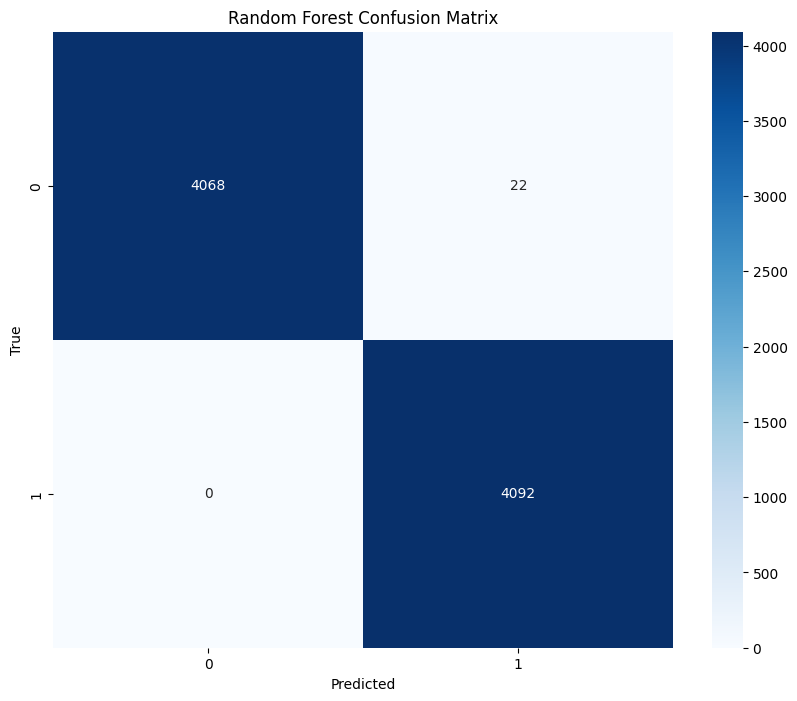

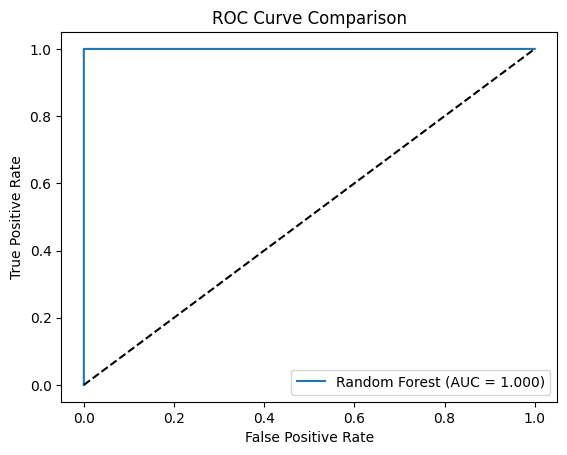

--- Logistic Regression ---
              precision    recall  f1-score   support

           0       0.67      0.75      0.71      4090
           1       0.71      0.63      0.67      4092

    accuracy                           0.69      8182
   macro avg       0.69      0.69      0.69      8182
weighted avg       0.69      0.69      0.69      8182



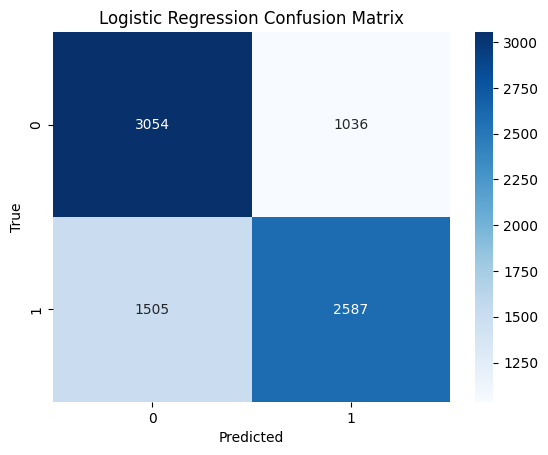

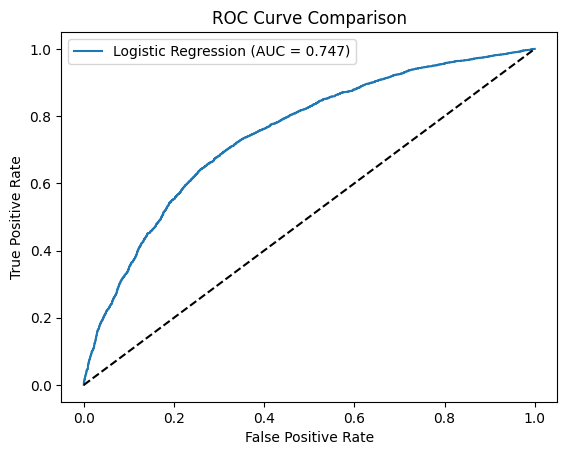

--- Gradient Boosting ---
              precision    recall  f1-score   support

           0       0.79      0.82      0.80      4090
           1       0.81      0.79      0.80      4092

    accuracy                           0.80      8182
   macro avg       0.80      0.80      0.80      8182
weighted avg       0.80      0.80      0.80      8182



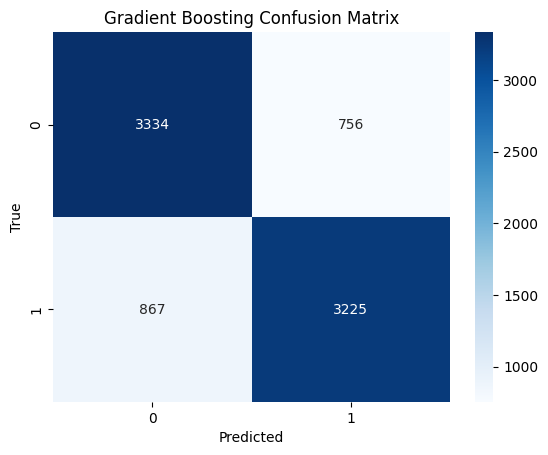

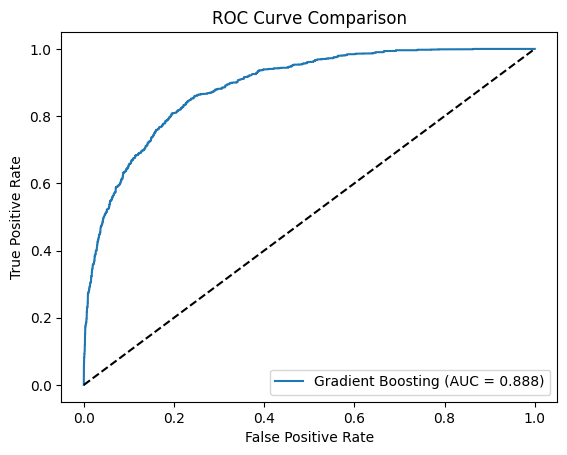

--- XGBoost ---
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      4090
           1       0.99      1.00      1.00      4092

    accuracy                           1.00      8182
   macro avg       1.00      1.00      1.00      8182
weighted avg       1.00      1.00      1.00      8182



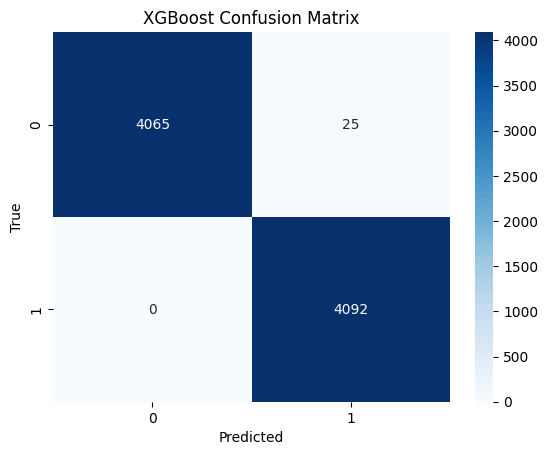

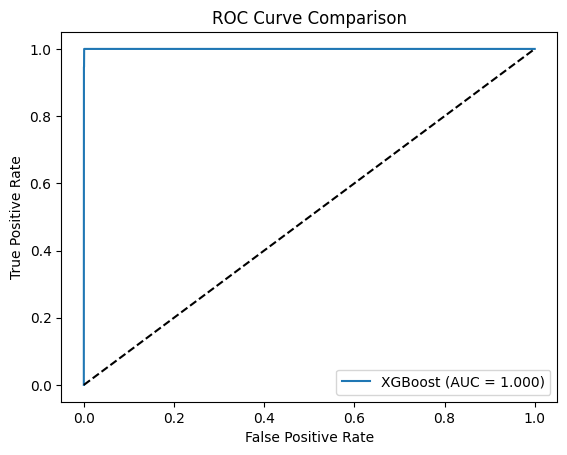

unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.


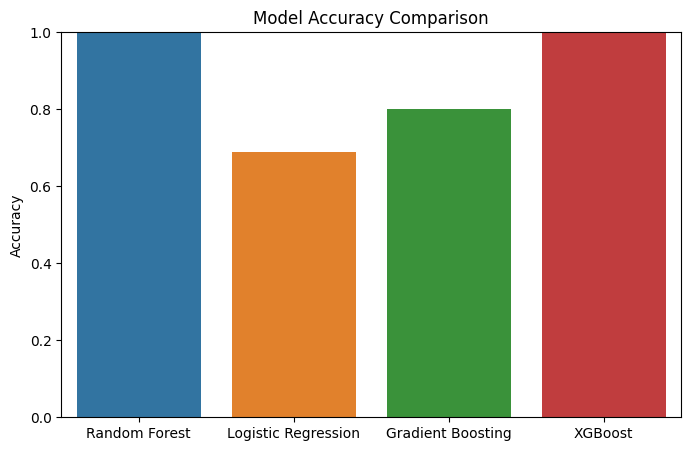

Computing SHAP values: 100%|██████████| 164/164 [10:28<00:00,  3.83s/it]


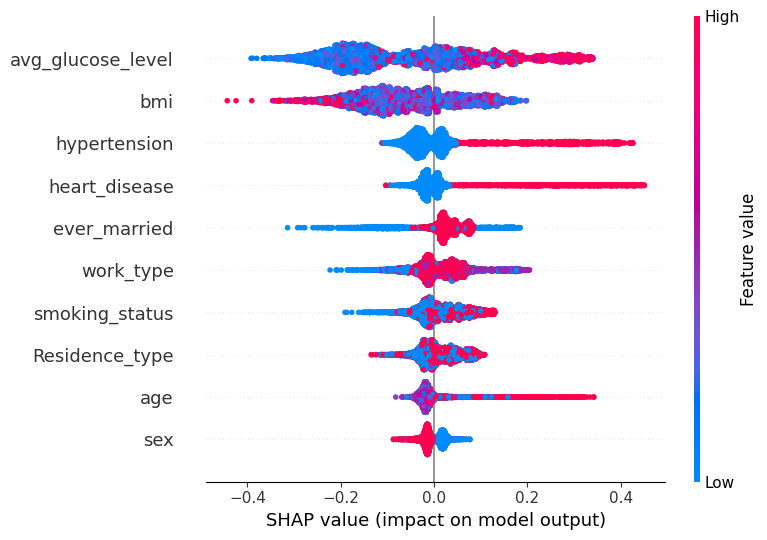

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import xgboost as xgb
# 1. Prepare data
from tqdm import tqdm
data = data.copy()  # your dataframe

# Encode categorical variables
cat_cols = ['sex', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
for col in cat_cols:
    data[col] = LabelEncoder().fit_transform(data[col].astype(str))

# Features and target
X = data.drop('stroke', axis=1)
y = data['stroke']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale numeric features (optional but recommended esp. for SVM, LogisticRegression)
num_cols = ['age', 'avg_glucose_level', 'bmi']
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

# 2. Define models

models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}


# 3. Train, predict and evaluate
results = {}
plt.figure(figsize=(10, 8))

for i, (name, model) in enumerate(models.items(), 1):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]
    
    print(f"--- {name} ---")
    print(classification_report(y_test, y_pred))
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
    # ROC curve
    auc = roc_auc_score(y_test, y_proba)
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.3f})')
    
    # Store accuracy for comparison
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc

    plt.plot([0,1], [0,1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve Comparison')
    plt.legend()
    plt.show()

# 4. Accuracy comparison barplot
plt.figure(figsize=(8,5))
sns.barplot(x=list(results.keys()), y=list(results.values()))
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.ylim(0, 1)
plt.show()

explainer = shap.TreeExplainer(models['Random Forest'])# 5. SHAP for interpretability (example for Random Forest)
batch_size = 50  # adjust as needed
shap_values_list = []

for i in tqdm(range(0, X_test.shape[0], batch_size), desc="Computing SHAP values"):
    batch = X_test.iloc[i:i+batch_size]
    shap_vals_batch = explainer.shap_values(batch)
    shap_values_list.append(shap_vals_batch)


# We need to concatenate per class across batches:
shap_values = []
num_classes = len(shap_values_list[0])
for class_idx in range(num_classes):
    class_shap = np.concatenate([batch[class_idx] for batch in shap_values_list], axis=0)
    shap_values.append(class_shap)

# Now shap_values is the same format as explainer.shap_values(X_test)

# Then plot summary:
shap.summary_plot(shap_values[1], X_test)


In [6]:
import joblib
import pickle
import os

# Assume all previous steps (data prep, training, evaluation) are done

save_dir = "./saved_models"
os.makedirs(save_dir, exist_ok=True)

# Save scaler
scaler_path = os.path.join(save_dir, "scaler.joblib")
joblib.dump(scaler, scaler_path)
print(f"Scaler saved to {scaler_path}")

# Save models and SHAP explainers
for name, model in models.items():
    # Save model
    model_path = os.path.join(save_dir, f"{name.replace(' ', '_').lower()}_model.joblib")
    joblib.dump(model, model_path)
    print(f"{name} model saved to {model_path}")
    
    # Save SHAP explainer
    if name == "Random Forest" or name == "Gradient Boosting" or name == "XGBoost":
        # Tree-based SHAP explainer
        explainer = shap.TreeExplainer(model)
    else:
        # For Logistic Regression (linear model), use KernelExplainer (slower)
        explainer = shap.KernelExplainer(model.predict_proba, shap.sample(X_train, 100))
    
    explainer_path = os.path.join(save_dir, f"{name.replace(' ', '_').lower()}_shap_explainer.pkl")
    with open(explainer_path, "wb") as f:
        pickle.dump(explainer, f)
    print(f"{name} SHAP explainer saved to {explainer_path}")


Scaler saved to ./saved_models/scaler.joblib
Random Forest model saved to ./saved_models/random_forest_model.joblib
Random Forest SHAP explainer saved to ./saved_models/random_forest_shap_explainer.pkl
Logistic Regression model saved to ./saved_models/logistic_regression_model.joblib
Logistic Regression SHAP explainer saved to ./saved_models/logistic_regression_shap_explainer.pkl
Gradient Boosting model saved to ./saved_models/gradient_boosting_model.joblib
Gradient Boosting SHAP explainer saved to ./saved_models/gradient_boosting_shap_explainer.pkl
XGBoost model saved to ./saved_models/xgboost_model.joblib
XGBoost SHAP explainer saved to ./saved_models/xgboost_shap_explainer.pkl


In [7]:
!zip -r meta_model.zip /kaggle/working/saved_models

  adding: kaggle/working/saved_models/ (stored 0%)
  adding: kaggle/working/saved_models/gradient_boosting_model.joblib (deflated 66%)
  adding: kaggle/working/saved_models/xgboost_shap_explainer.pkl (deflated 76%)
  adding: kaggle/working/saved_models/logistic_regression_shap_explainer.pkl (deflated 69%)
  adding: kaggle/working/saved_models/scaler.joblib (deflated 38%)
  adding: kaggle/working/saved_models/random_forest_model.joblib (deflated 80%)
  adding: kaggle/working/saved_models/xgboost_model.joblib (deflated 67%)
  adding: kaggle/working/saved_models/gradient_boosting_shap_explainer.pkl (deflated 72%)
  adding: kaggle/working/saved_models/random_forest_shap_explainer.pkl (deflated 79%)
  adding: kaggle/working/saved_models/logistic_regression_model.joblib (deflated 39%)


In [12]:
data.work_type.value_counts()

work_type
4    25570
3     9236
2     5588
1      431
0       85
Name: count, dtype: int64

In [17]:
data.sex.dropna(inplace=True)

In [18]:
cat_cols = ['sex', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

# Dictionary to store all label encoders
label_encoders = {}

# Create and fit label encoders for each categorical column
for col in cat_cols:
    print(f"\nProcessing column: {col}")
    print(f"Unique values: {data[col].unique()}")
    
    # Create label encoder
    le = LabelEncoder()
    
    # Fit and transform the column
    data[col] = le.fit_transform(data[col].astype(str))
    
    # Store the encoder
    label_encoders[col] = le
    
    print(f"Encoded values: {data[col].unique()}")
    print(f"Mapping: {dict(zip(le.classes_, le.transform(le.classes_)))}")

# Save label encoders
with open('label_encoders.pkl', 'wb') as f:
    pickle.dump(label_encoders, f)
print(f"\n✅ Label encoders saved as 'label_encoders.pkl'")


Processing column: sex
Unique values: [1 0 2]
Encoded values: [1 0 2]
Mapping: {'0': 0, '1': 1, '2': 2}

Processing column: ever_married
Unique values: [1 0]
Encoded values: [1 0]
Mapping: {'0': 0, '1': 1}

Processing column: work_type
Unique values: [4 3 2 1 0]
Encoded values: [4 3 2 1 0]
Mapping: {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4}

Processing column: Residence_type
Unique values: [1 0]
Encoded values: [1 0]
Mapping: {'0': 0, '1': 1}

Processing column: smoking_status
Unique values: [1 0]
Encoded values: [1 0]
Mapping: {'0': 0, '1': 1}

✅ Label encoders saved as 'label_encoders.pkl'


In [20]:
!pip show torchvision

Name: torchvision
Version: 0.21.0+cu124
Summary: image and video datasets and models for torch deep learning
Home-page: https://github.com/pytorch/vision
Author: PyTorch Core Team
Author-email: soumith@pytorch.org
License: BSD
Location: /usr/local/lib/python3.11/dist-packages
Requires: numpy, pillow, torch
Required-by: easyocr, fastai, timm


In [22]:
!pip show shap

Name: shap
Version: 0.44.1
Summary: A unified approach to explain the output of any machine learning model.
Home-page: 
Author: 
Author-email: Scott Lundberg <slund1@cs.washington.edu>
License: MIT License
Location: /usr/local/lib/python3.11/dist-packages
Requires: cloudpickle, numba, numpy, packaging, pandas, scikit-learn, scipy, slicer, tqdm
Required-by: 
